#### import module

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import hashlib
import sys
import random
import os
import pandas as pd

#### Haar Transform

##### Forward IWT

In [2]:
def forwardIWT(matrix1):
    m,n=matrix1.shape
    matrix=matrix1.tolist() #matrix is a list
    
    #row operation
    row = list()
    for i in range(m):
        a=[]
        d=[]      
        for p in range(0,m):
            if m>2*p+1: #how many time we get the a & d value        
                x=matrix[i] #get the rows                
                t=math.floor((x[2*p]+x[2*p+1])/2)                
                a.append(t)
                t=math.floor(x[2*p]-x[2*p+1])                
                d.append(t)            
                    
        combine=a+d #combine the list     
        row.append(combine)
        a.clear()
        d.clear()

  
    #column Operation
    column=list() #operation w.r.t 'row' matrix
    row1=[[x[i] for x in row] for i in range(len(row[0]))] #transpose of row
    for i in range(n):
        a=[]
        d=[]      
        for p in range(0,n):
            if n>2*p+1: #how many time we get the a & d value        
                x=row1[i] #get the rows                
                t=math.floor((x[2*p]+x[2*p+1])/2)                
                a.append(t)
                t=math.floor(x[2*p]-x[2*p+1])                
                d.append(t)            
                    
        combine=a+d #combine the list     
        column.append(combine)
        a.clear()
        d.clear()

    result=[[x[i] for x in column] for i in range(len(column[0]))] #again transpose of column matrix
    res=np.array(result)
    final=np.reshape(res, (m,n))
    return final

##### Inverse IWT

In [3]:
def inverseIWT(matrix1):
    matrix=list()
    m,n=matrix1.shape
    matrix=matrix1.tolist() #matrix is a list

    #Column Operation
    trans_matrix=[[x[i] for x in matrix] for i in range(len(matrix[0]))] #transpose of matrix
    column_tr=list()
    for i in range(n):
        flag=trans_matrix[i]
        a=flag[:n//2]
        d=flag[n//2:]
        temp=list()
        for p in range(0,n):
            if n>2*p+1: #how many time we get the value
                x1=a[p]+math.floor((d[p]+1)/2)
                temp.append(x1)
                x2=x1-d[p]
                temp.append(x2)
        column_tr.append(temp)


    #row operation
    column=[[x[i] for x in column_tr] for i in range(len(column_tr[0]))] #transpose of column matrix 
    row=list()
    for i in range(m):
        flag=column[i]
        a=flag[:n//2]
        d=flag[n//2:]
        temp=list()
        for p in range(0,m):
            if m>2*p+1: #how many time we get the value
                x1=a[p]+math.floor((d[p]+1)/2)
                temp.append(x1)
                x2=x1-d[p]
                temp.append(x2)
        row.append(temp)

    res=np.array(row)
    result=np.reshape(res, (m,n))
    return result 

#### Histogram Shifting

##### Shifting

In [4]:
def histogram_shifting(matrix, keyword):
    row,col=matrix.shape
    img=matrix.flatten() #image in 1D
    list_img=list(set(img))
    sort_pixel=sorted(list_img)

    freq=[] #store freq of each element in sorted manner of element
    for i in sort_pixel:
        freq.append(list(img).count(i))
    key_size=len(keyword) #size of payload
    print("Maximum freq in the image",max(freq))
    
    
    #find base point
    flag=0
    x=sorted(list_img)
    for i in freq:
        if i>=key_size:            
            temp=freq.index(i)            
            if x[temp]>0 or x[temp]<=0:
                base_point=x[temp] #get base point
                flag +=1
    if flag==0:
        print("No base Point")
        sys.exit()
        # return False, False

   
    '''cahnge value of base point+1 and no. of basepoint>len(keyword),
    i.e. more no of base point the the length of keyword,
    then make those extra base point increase by 2'''   
    flag=len(keyword)
    count=0
    for j in range(0, len(img)):
            if img[j]==base_point+1:
                img[j] +=1
                
            if img[j]==base_point:
                count +=1
                if count>flag:
                    img[j] = img[j]-1 #chnage the extra bp to pixel with the previous value
                            #eg. bp=152 then extra bps will be 151
   
    #histogram shifting
    index=0
    key=str(keyword)
    for item in range(0, len(img)):
        if img[item]==base_point and index<len(key):
            if key[index]=='0':
                img[item]= img[item] #string is 0 then value is 0
            elif key[index]=='1':
                img[item] += 1 #string is 0 then value increase by 1
            index += 1

    result=np.resize(img, (row,col))
    return result,base_point
                

##### Extraction

In [5]:
def histogram_extract(matrix, base_point):
    img=matrix.flatten()
    payload=''
    for item in img:
        if item==base_point:
            payload += '0'
        elif item==base_point+1:
            payload +='1'
    return payload

#### SHA 256

In [6]:
def sha256_code(img):
    img_str = str(img)#convert to string
    
    # Compute the SHA-256 hash of the string representation
    sha256_hash = hashlib.sha256(img_str.encode('utf-8'))
    
    # Get the hexadecimal representation of the hash
    hex_digest = sha256_hash.hexdigest()
    
    # Convert the hexadecimal digest to binary
    binary_digest = bin(int(hex_digest, 16))[2:].zfill(256)
    return hex_digest,binary_digest

#### Break & Make image into 4parts

In [7]:
#extract 1/4th Components of image

def extract_quarter_components(image):
    height, width = image.shape

    # Determine the indices for slicing each quadrant
    half_height = height // 2
    half_width = width // 2

    # Extract each quadrant
    top_left = image[:half_height, :half_width]
    top_right = image[:half_height, half_width:]
    bottom_left = image[half_height:, :half_width]
    bottom_right = image[half_height:, half_width:]

    return top_left, top_right, bottom_left, bottom_right


#Make the image from 4parts
def reconstruct_image(top_left, top_right, bottom_left, bottom_right):
    height, width = top_left.shape

    # Create an empty array to hold the reconstructed image
    reconstructed_image = np.empty((height * 2, width * 2))

    # Place each component in its respective position
    reconstructed_image[:height, :width] = top_left
    reconstructed_image[:height, width:] = top_right
    reconstructed_image[height:, :width] = bottom_left
    reconstructed_image[height:, width:] = bottom_right

    return reconstructed_image

#### Convert Image to Binary

In [8]:
def binaryImage(img):
    x=list()
    for row in img:
        for num in row:
            y=format(num, '08b')
            x.append(y)  # '08b' ensures leading zeros for each byte
    str_bin=''
    for item in x:
        str_bin+=item
    return x, str_bin

#### Arnold's Cat Map

In [9]:
def arnold_cat_map(image,iteration):
    row,col=image.shape
    process_img = np.zeros_like(image)
    original_img=image.copy()

    # plt.title(f'Original Image')
    # plt.imshow(image,cmap='gray')
    # plt.axis('off')
    # plt.show()
    
    #calculating each pixel
    count=1
    while (count<=iteration):
        for x in range(row):
            for y in range(col):
                nx=(2*x+y)%row
                ny=(x+y)%col
                process_img[nx,ny] = image[x,y]
        image=process_img.copy()
        count +=1   
    return process_img
    

#### Random Sequence List

In [10]:
def randomSequence(Size):
     random.seed(Size)
     for i in range(Size):
         if i > 2:
             HCF = math.gcd(i, Size)
             if HCF == 1:
                 break
     Number = random.randint(0, Size-1)
     Temp = Number
     Result = [Temp]
     while True:
         Number = (Number + i) % Size
         if Number == Temp:
             break
         Result.append(Number)
     return Result

#### Convert Binary Image to 2D Image

In [11]:
def decimalImage(binary_list,size):
    decimal_list = []  # Initialize an empty list to store decimal integers
    
    # Iterate over each binary string in the input list
    for binary_str in binary_list:
        decimal_int = int(binary_str, 2)  # Convert the binary string to decimal integer
        decimal_list.append(decimal_int)  # Add the decimal integer to the result list

    #convert to a 2D list equal to size of secert image
    result=list()
    result = [decimal_list[i*size : (i+1)*size] for i in range(size)]   
    return result

#### Convert Text to binary & Binary to text & Binary to Text

In [12]:
def text2binary(text):
    binary_text = ''.join(format(ord(char), '08b') for char in text)
    return binary_text

def binary2text(binary_text):
    # Split the binary string into 8-bit substrings
    binary_list = [binary_text[i:i+8] for i in range(0, len(binary_text), 8)] 
    # Convert binary to text
    text = ''.join(chr(int(binary, 2)) for binary in binary_list)
    return text

def binary2number(binary_string):
    # Split the binary string into 8-bit segments
    binary_segments = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]    
    # Convert each 8-bit binary segment to integer
    integer_list = [int(segment, 2) for segment in binary_segments]    
    return np.array(integer_list)

#### Hamming Code

In [13]:
#Hamming Code
def calcRedundantBits(m):
    for i in range(m):
        if(2**i >= m + i + 1):
            return i     

def posRedundantBits(data, r):
    j = 0
    k = 1
    m = len(data)
    res = ''
    for i in range(1, m + r+1):
        if(i == 2**j):
            res = res + '0'
            j += 1
        else:
            res = res + data[-1 * k]
            k += 1
    return res[::-1]

def calcParityBits(arr, r):
    n = len(arr)
    for i in range(r):
        val = 0
        for j in range(1, n + 1):
            if(j & (2**i) == (2**i)):
                val = val ^ int(arr[-1 * j])
        arr = arr[:n-(2**i)] + str(val) + arr[n-(2**i)+1:]
    return arr

def detectError(arr, nr):
    n = len(arr)
    res = 0
    for i in range(nr):
        val = 0
        for j in range(1, n + 1):
            if(j & (2**i) == (2**i)):
                val = val ^ int(arr[-1 * j])
        res = res + val*(10**i)
    return int(str(res), 2)


'''Hamming Code Insertion'''
def hammingcode(bindata): #give binary string as argument
    output=''
    for i in range(0,len(bindata),8):
        data=bindata[i:i+8]
        m=len(data)
        r=calcRedundantBits(m)
        arr=posRedundantBits(data,r)
        arr=calcParityBits(arr,r)
        output+=str(arr)
    return output,r #return binary string along with parity & return no. of redundent bits(r)

'''Hamming Code Error Correction'''
def removeerror(outdata,r): #takes argument the bit string along with parity & return no. of redundent bits(r)
    output=''
    for i in range(0,len(outdata),12):
        data=outdata[i:i+12]
        pos=detectError(data,r)
        if pos==0:
            temp=data[0:4]+data[5:8]+data[9]
        else:
            pos=len(data)-pos+1
            if data[pos-1]=='0':
                data=data[0:pos-1]+'1'+data[pos:]
            else:
                data=data[0:pos-1]+'0'+data[pos:]
            
            temp=data[0:4]+data[5:8]+data[9]
        output+=temp
    return output #return correct binary string

## Image Hiding

In [14]:
def imageHiding(image, secret, epr):
    #1. Forward IWT
    fIWT_img=forwardIWT(image) #apply 1st time to image
    LL,HL,LH,HH = extract_quarter_components(fIWT_img)
    
    #2.SECRET IMAGE TO SHA256 & CONVERT IT TO BINARY    
    hash_image,hash_bin=sha256_code(secret)
    
    #3. Histogram Shifting of secret image to LL & SHA to HH
    secret_bin, secret_str=binaryImage(secret) #convert to binary

    # '''4. Using HAMMING CODE(HC) to Secret Image, SHA, EPR'''
    # HC_secret_str, redundent_secret_str=hammingcode(secret_str) #use HC to Secret image & store the HC coded bits & r
    # HC_hash_bin, redundent_hash_bin=hammingcode(hash_bin) #HC on SHA
    # HC_epr, redundent_epr=hammingcode(epr) #HC on EPR text

    #5. Histogram Shifting of secret image to HH & SHA to HH & EPR to LH
    LL_coded, bp1=histogram_shifting(LL, hash_bin) #SHA coded to LL
    HH_coded, bp2=histogram_shifting(HH, secret_str) #Secret Image coded to HH
    LH_coded, bp3=histogram_shifting(LH, epr) #EPR coded to LH 
    print(bp1,bp2,bp3)
    
    #4. Hiding Base Points to LH
    # row1, col1=LH.shape
    # LH[row1//2][col1//2]=bp1
    # LH[row1//4][col1//4]=bp2
    
    #5. Combine 4 Components
    forwardIWT_Stego=reconstruct_image(LL_coded, HL, LH_coded, HH_coded)
    Stego_Image=inverseIWT(forwardIWT_Stego) #again Inverse IWT to image


    #Return stego image & base points(bp1=LL, bp2=HH, bp3=LH) & Redundent bits  
    return Stego_Image, bp1,bp2,bp3 

## Image Extraction

In [15]:
def imageExtraction(stego_img,bp1,bp2,bp3):
    #1. Forward IWT
    fIWT_img=forwardIWT(stego_img) #apply 1st time to image
    LL1,HL,LH1,HH1 = extract_quarter_components(fIWT_img)
    
    # Get base points
    # row2, col2=LH.shape
    # bp1=LH[row2//2][col2//2] #bp of SHA
    # bp2=LH[row2//4][col2//4] #bp of secret image
    
    #2. Histogram Extraction from LL & HH
    extract_secret_bin=histogram_extract(HH1,bp2) #extract secret image in binary,bp2=159
    extract_sha_bin=histogram_extract(LL1, bp1) #extract SHA in binary, bp1=15
    extract_epr_bin=histogram_extract(LH1, bp3) #extract EPR binary from LH, bp3

    
    # '''#3. Hamming Code Correction'''
    # extract_secret_bin=removeerror(HC_extract_secret_bin,redundent_secret_str) #correct code of secert image wrt redundent bits
    # extract_sha_bin=removeerror(HC_extract_sha_bin,redundent_hash_bin) #correct SHA
    # extract_epr_bin=removeerror(HC_extract_epr_bin,redundent_epr) #Correct EPR text


    #4. Convert the binary str of image to Actual Secret Image
    extract_secret_lis=list()
    for i in range(0, len(extract_secret_bin) - 1, 8):
            pair = extract_secret_bin[i:i+8]  # Extract a pair of consecutive digits
            extract_secret_lis.append(pair) 
    
    #convert to 2d decimal array
    size=int(math.sqrt(len(extract_secret_lis)))#find size, square image so row & col value same
    extract_secret_decimal=decimalImage(extract_secret_lis,size)
    extract_secret_image=np.array(extract_secret_decimal)


    return extract_secret_image, extract_sha_bin, extract_epr_bin #return secret image & SHA in binary from stego image & epr

## Calculate Erros

#### calculate normalized_cross_correlation (NCC)

In [16]:
def NCC(img1, img2):
    # Ensure both images have the same depth and type
    gray1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    gray2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Perform template matching
    result = cv2.matchTemplate(gray1, gray2, cv2.TM_CCORR_NORMED)

    # Extract the maximum correlation coefficient
    max_corr_coeff = cv2.minMaxLoc(result)[1]

    return max_corr_coeff

#### Salt & Peeper Code

In [17]:
from skimage.util import random_noise
def salt_pepper_noise(img,density):
    noise_img = random_noise(img, mode='s&p',amount=density)
    # The above function returns a floating-point image
    # on the range [0, 1], thus we changed it to 'uint8'
    # and from [0,255]
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    return noise_img.astype(np.float64)

In [18]:
def saltandpepper_noise(image, density):  
    # Get the image size
    height, width = image.shape
    
    # Create a noise mask
    # 1 represents pepper noise, 2 represents salt noise
    noise_mask = np.random.choice([0, 1, 2], size=(height, width), p=[1-density, density/2, density/2])
    
    # Create the noisy image
    noisy_image = image.copy()
    
    # Apply pepper noise (set to 0)
    noisy_image[noise_mask == 1] = 0
    
    # Apply salt noise (set to 255)
    noisy_image[noise_mask == 2] = 255

    return noisy_image


<function matplotlib.pyplot.show(close=None, block=None)>

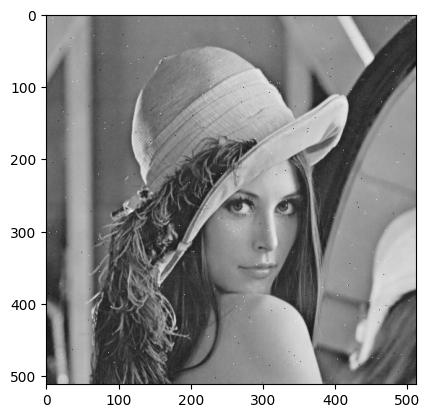

In [77]:
cover=cv2.imread("C:\Study Meterial\Semester Project\Practical\WORK\Cover Images\lena.tiff",0)
x=salt_pepper_noise(cover,density=0.1)
y=saltandpepper_noise(cover,density=0.001)
plt.imshow(y.astype(np.uint8),cmap='gray')
plt.show

#### Without Attack on LENA, hiding

Maximum freq in the image 708
Maximum freq in the image 6159
Maximum freq in the image 8740
212 5 3


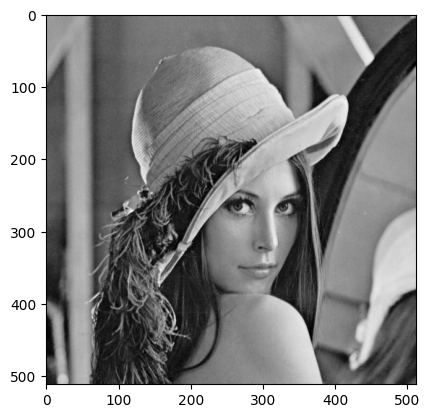

In [20]:
cover=cv2.imread("C:\Study Meterial\Semester Project\Practical\WORK\Cover Images\lena.tiff",0)
sec=cv2.imread("C:\Study Meterial\Semester Project\Practical\WORK\Stego Image.png",0)
secret=cv2.resize(sec,(16,16), interpolation=cv2.INTER_AREA)
file = open("C:\Study Meterial\Semester Project\Practical\WORK\Without Attack\sample epr - Copy.txt", 'r')
EPR_txt = file.read()
file.close()
EPR_bin=text2binary(EPR_txt) #EPR text in binary
secret_cat=arnold_cat_map(secret,iteration=7)


#STEGO IMAGE
stego_img, bp1,bp2,bp3=imageHiding(cover,secret_cat, EPR_bin) 
plt.imshow(stego_img,cmap='gray')
plt.show()

#### Extraction

Patient Information:
Name: John Doe
Gender: Male
Date of Birth: January 1, 1980
Address: 123 Main Street, Anytown, USA
Phone: (555) 123-4567

Medical History
Medications: Aspirin 81mg daily, Lisinopril 10mg daily
Past Medical History: Hypertension, Type 2 Diabetes Mellitus

Machine Information:
Machine Name: HealthMaster 3000
Serial Number: HM3000-12345



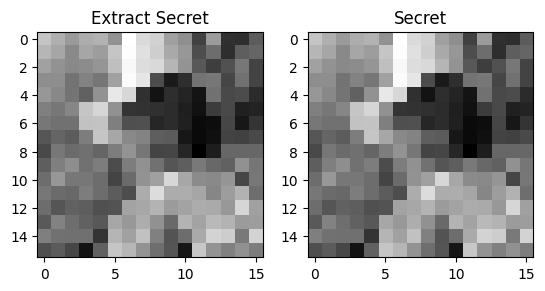

In [21]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(stego_img,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat,cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret,cmap='gray')
plt.title('Secret')
plt.show()

### 1) Salt & Peeper Noise 

#### Attacks

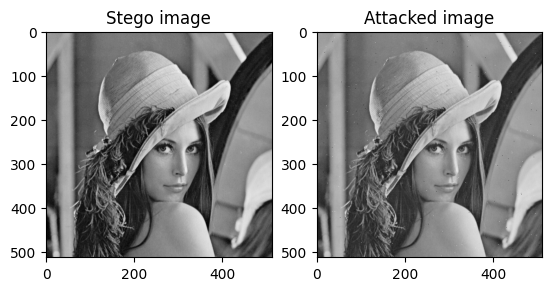

In [22]:
attack_img_saltpeeper=saltandpepper_noise(stego_img.astype(np.uint8),density=0.001)

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_saltpeeper,cmap='gray')
plt.title('Attacked image')
plt.show()

#### Extraction

Patient JÜÌÞäÚÂèÒÞÜtÂÚÊt)½¡¸½)¹ÈÑkc(R#£){1K£AÑSs«'Â ¤L®ngD&Fd	¬--Ä
nL¬®-Ï.îíÅ
íÉN
MÂYYq°¶$4¹tory
Medications: Aspirin 81mg daily, LifÒÜÞàäÒØ@b`ÚÎ@ÈÂÒØä)AÍÐ5F6Â7F÷'¢W'FVç6öâÂGR"F&N®d	Y[]\ÂXXÚ[H[ÜXZ4··&°±hinJ@ÂÚÊt@ÊÂØèÐÂæèÊä@LÀÀÀ)MÉ¥°9ÕµÑBiÓ#3C!


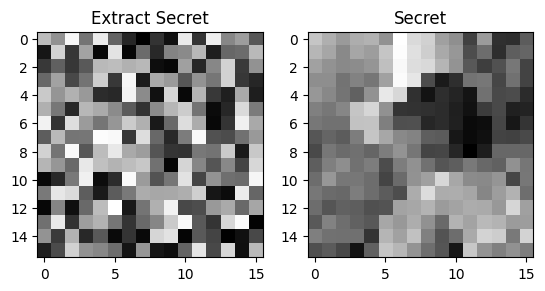

In [23]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_saltpeeper.astype(np.float64),bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [24]:
NCC(extract_secret_image,secret_cat)

0.784580409526825

In [25]:
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

NCC(epr_inserted,epr_extracted)

0.8422244787216187

### 2)Gaussian Noise

#### code

In [26]:
def gaussian_noise(img,mean,var): #bg
    noise_img = random_noise(img, mode='gaussian',clip=True,mean=mean,var=var)
    #noise_img=noise_img.astype('uint8')
    noise_img = np.array(255*noise_img, dtype = 'uint8')
    return noise_img


def add_gaussian_noise(image, variance):
     # Generate Gaussian noise with zero mean and specified variance
     mean = 0
     sigma = np.sqrt(variance)
     gaussian_noise = np.random.normal(mean, sigma, image.shape)
     # Add the Gaussian noise to the image
     noisy_image = image + gaussian_noise
     return noisy_image


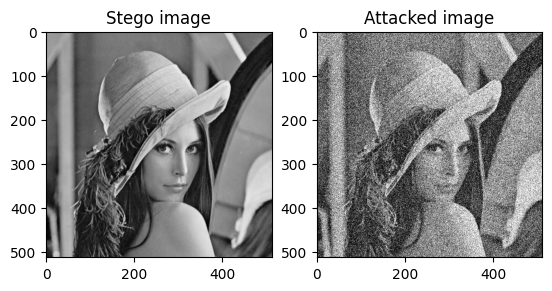

In [27]:
attack_img_gaussian=gaussian_noise(stego_img.astype(np.uint8),mean=0,var=0.05)
plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_gaussian,cmap='gray')
plt.title('Attacked image')
plt.show()

4ÀÓ$ßd·¸A9îùeöÌxÎþµRøWÌ  Û)jiY!`¦/ÀAýhßÐÝàXsFY&[z"


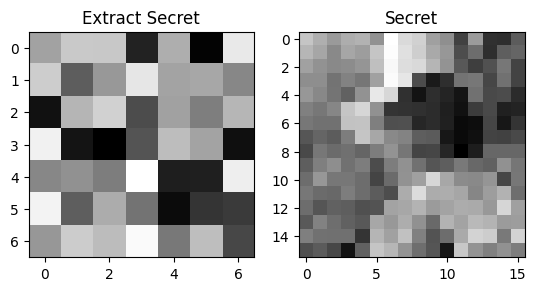

In [28]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_gaussian.astype(np.float64),bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [29]:
NCC(extract_secret_image,secret_cat)

0.8619922399520874

In [30]:
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

NCC(epr_inserted,epr_extracted)

0.8436777591705322

### 3)Median Blur

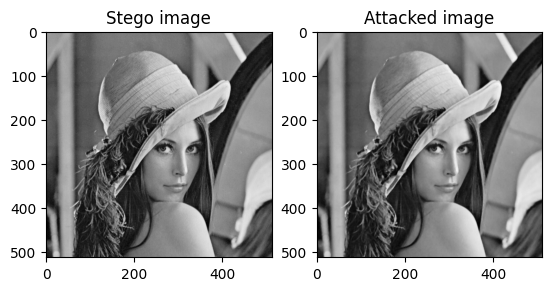

In [31]:
attack_img_median=cv2.medianBlur(stego_img.astype(np.uint8),3)
plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_median,cmap='gray')
plt.title('Attacked image')
plt.show()

A0Ú5H@Ð	¨PÄ
m2%rÐR¨JDO	 Ä%Y¬OÑ 	ð¦HRdlå	R(ÉI·ÐG6\nJQ! ²YB¡A¸´áj)°Ih êÇ ¼
5/Äðð¢KPô@òhF<@`*oÂ}Ô¨Cf!0A¾`àQPh²±R)ÊÁVAÆÎ`K"M%(µÈ@
ô. á°p¦&|l1¡h 
ÈYA Ñ¡bJTÐ*]¸ÍP	Y+ÁD"É ÕDXD±ÐZÀÁq](@^O¡ ÀX&±b?(Ð © ¸zÎIáÖÐJDßxÚÑÔ16"Î»


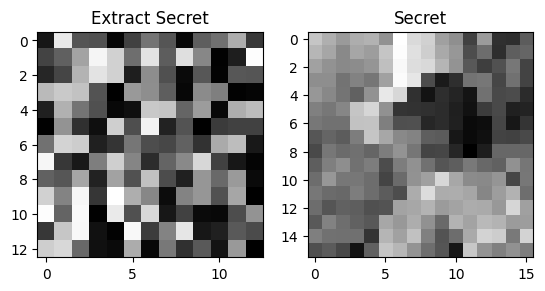

In [32]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_median.astype(np.float64),bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [33]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.7798522710800171
0.7602823972702026


### 4)Histogram Equalization

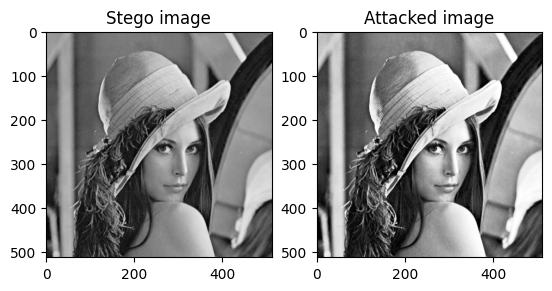

In [37]:
attack_img_hist= cv2.equalizeHist(stego_img.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_hist,cmap='gray')
plt.title('Attacked image')
plt.show()

önEÂ$ÂQiUÒ(=È²HMý1òüë¿¨DoIöAÖè"æC»Q{q`Á# 4§í«Ø'qAfÑ7ö ÞÁð&´É*ªo©HÅRajJ¶s#q¡yÅ4%ûÇá°Wø£ø2d[!c©,ÐPÇ8xc#µ91ÿQ¨ÈSBjË®Z¹æ¤¦@þ®ÜÀ¿D¼^`[è®Úc8²aQ#7\eÏ$ÁÉJ×â6lîºr¹àPîe³ËnÄ"È²´Ò`iÀCÁ2ÔéíbÑ&`çêå>Å¾VYi ;âÎA
¿M91®II£àÅZÁDSfÒþ¼)Ë£8æ¼î}ÇTäjN³dx&38{bLþÀ
Å¥þIýà»; WÃRß&ID¸^b3$àÿ8º¼dfÒip	4à+L»ÈN¨¤ÕÂï&¾.V{FA¤ûÛb>) Õ\ê!{&=¬8áá@±4tQçKð	Ð§ñÞï"ýÀ9W3}Ì¢÷ªfåW8uÝñ<>ÇQMãAj}¤|`@oÐñáQ8þ¶z¡­tTð×Ö)8:xª~`BC`ð°sM


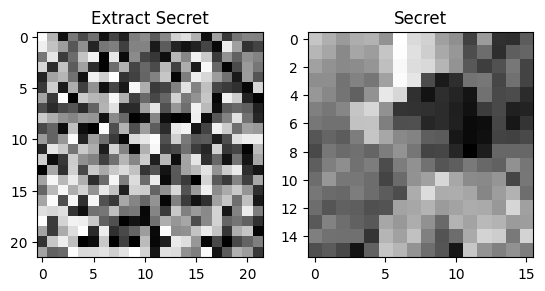

In [49]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_hist,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [48]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.8195464611053467
0.8202852606773376


### 5)Image Sharpning

#### code

In [41]:
def sharpen_image(image):
     # Define the sharpening kernel
     kernel = np.array([[-1, -1, -1],
     [-1, 9, -1],
     [-1, -1, -1]])
     # Apply the kernel to the image
     sharpened_image = cv2.filter2D(image, -1, kernel)
     return sharpened_image

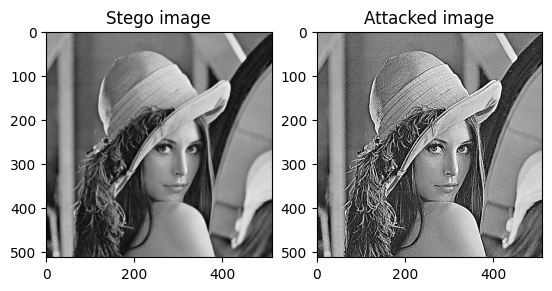

In [44]:
attack_img_sharp= sharpen_image(stego_img.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_sharp,cmap='gray')
plt.title('Attacked image')
plt.show()

jRçI]xW[Tå7ø´¢mEEâNÓ3\b¸÷	>#Sñ¦º]Ãûûlø	áÜä,AGãëÙajÔ3\b¸÷	>#Sñ¦º]Ãûûlø	
øëÂ§4×egì­ºÌ±?ÑÞmZÊ.¡pÝê¹h<];zmä{pFÍ#ÔXC%hU¶W¦í"E[ð0Ï³Jî¬&1¢±ÊÒ9%-Ñyì ;ylÍ?¤¨R4_Wó±á$§mM¥_C=


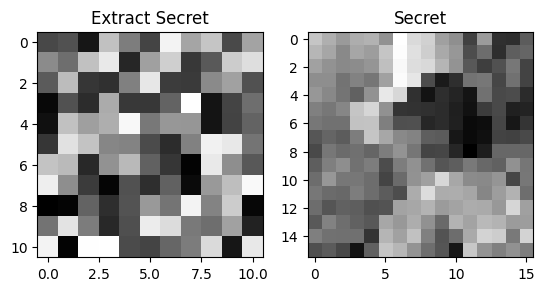

In [45]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_sharp,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [46]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.8209125399589539
0.8187617659568787


### 6)Crop

#### code

In [86]:
def crop(image, crop_percentage): #centre crop
    height, width = image.shape
    # Calculate the boundaries of the central cropped region
    crop_factor = crop_percentage / 100
    start_row = int(height * (1 - crop_factor) / 2)
    end_row = int(height * (1 + crop_factor) / 2)
    start_col = int(width * (1 - crop_factor) / 2)
    end_col = int(width * (1 + crop_factor) / 2)

    # Set the central cropped region to white
    image[start_row:end_row, start_col:end_col] = 255
    return image

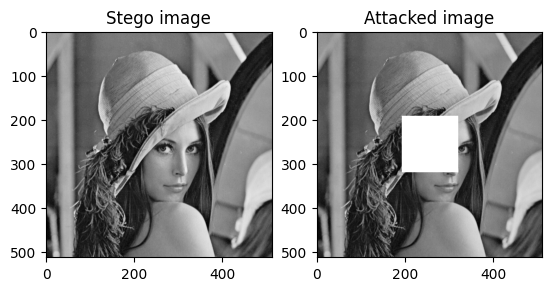

In [90]:
attack_img_crop= crop(stego_img.astype(np.uint8),25)

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_crop,cmap='gray')
plt.title('Attacked image')
plt.show()

Patient Information:
Name: John Doe
Gender: Male
Date of Birth: January 1, 1980
Address: 123 Main Street, Anytown, USA
Phone: (555) 123-4567

Medical History
Medications: Aspirin 81mg daily, Lisinopril 10k(1hÇ ÆèBY#,nÂ4»£\td<àÅÏFVçKmÁyqXTÊ®@[1¥Ñ« ¤ØZÝ($·3|aÑ­íô®ÆÊAµ:	ÂÝªæ ¦ÊäÒÂØ@êÚÄÊät@f```Zbdfhj



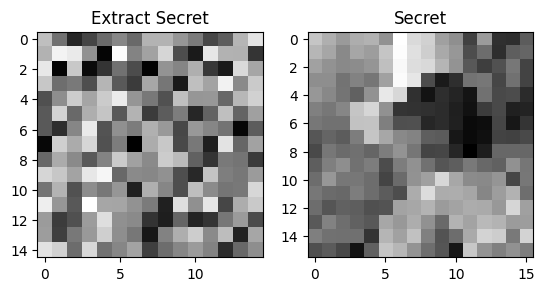

In [91]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_crop,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [92]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.8477846384048462
0.8788323998451233


### 7)Resize

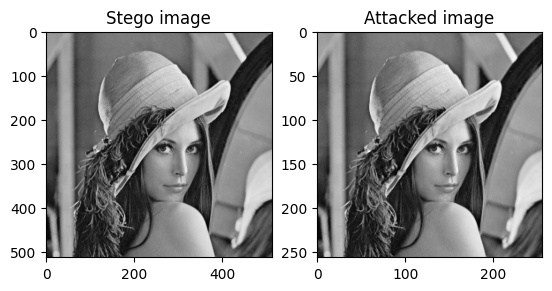

In [94]:
attack_img_resize= cv2.resize(stego_img.astype(np.uint8),(256,256), interpolation=cv2.INTER_AREA)

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_resize,cmap='gray')
plt.title('Attacked image')
plt.show()

 AÈH 4¢#< ÉÈr$«ÆHÀ/Hæu?á"Øst2<¢®æ[=»h 6% ÃeHÀUZ%4\(áQHa%ÁHÁÈÄ°Õ ÎÂ"?,H¡À°Ú9¨"³M÷m¿Â<3ÂDÐãYàÃði#©}¤  w,	


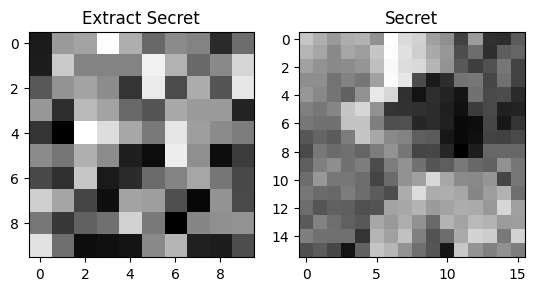

In [95]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_resize,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [96]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.8464524745941162
0.781610369682312


### 8)Reflection

### code

In [97]:
def reflection(img):
    rows, cols = img.shape
    M = np.float32([[1, 0, 0],
                    [0, -1, rows],
                    [0, 0, 1]])
    reflected_img = cv2.warpPerspective(img, M,(int(cols),int(rows)))
    return reflected_img

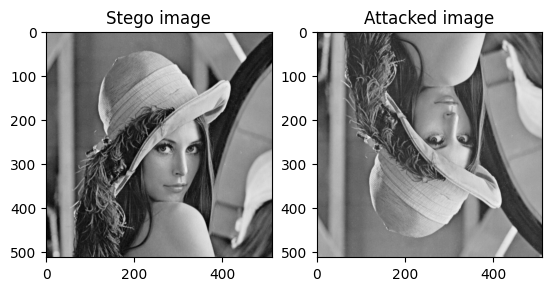

In [100]:
attack_img_mirror= reflection(stego_img.astype(np.uint8))

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_mirror,cmap='gray')
plt.title('Attacked image')
plt.show()

¬ ! à´@ÄDàGÀ"#\I * x@9Ý7öõ	9R­Skn4êMO	ë7 ldØ£ëFd¨C«WB0¢ABÝ)a&$ª¨¬\VA[ *P@+yk*Tb2±ñ©©z&$AÔ.a'	QTòDWÆús: l )|M-°±ÕÂÔ8Ø$(À3#
¡äh¬CÆ¸°¤ò]±ôQZVõj {qj \ÊÃ½{¦  (q ÉAVé@¡ÔÜÝ*`nÓìX£5ÑpKàÞpÐQbp.Là0&(Ì7¨#i6ÍC1©äÁÞ 0[,@P¸<êû¯ xÂhÁÔX$ ó© 	 I ,¨àTXÊØ )haÁ¾ Ë²TðÂx	¾põ#`ëPyÙyÂ ²®)5q L	ÈiórÉ$ Mº LslK=AD;Íï%(dI·
Á¸fE|-qÁá6`ðÈF¤¸B ¨ª¡Þ]'ÓOÈ¢°'
DÁÅQ ²B@¨ndÌ,(h­<D«ÀM|¥øNÀ^Í¬mx¤HÜJ¢¢·0,¤*46 RÔÅMfÎ
À©?z9ä@VÐQp\c"¼p³xNC(,iè WJà-


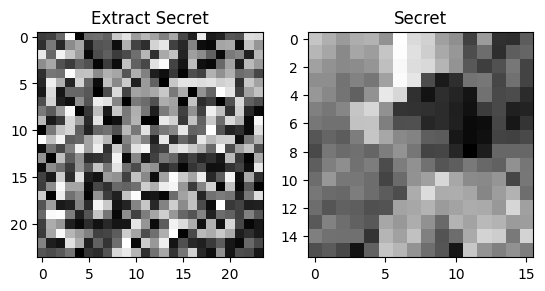

In [101]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_mirror,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [103]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.7972204685211182
0.7743988037109375


### 9)Average Filtering

#### code

In [104]:
def average_filter(image, kernel_size):
 # Apply average filtering
 blurred_image = cv2.blur(image, kernel_size)
 return blurred_image

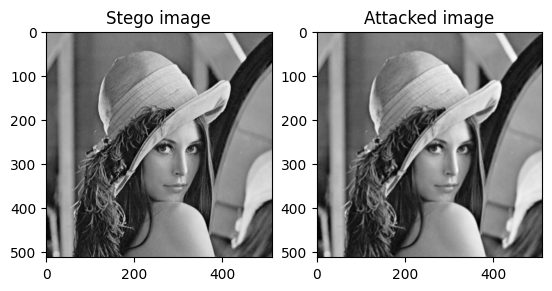

In [107]:
attack_img_avg= average_filter(stego_img.astype(np.uint8),kernel_size=(3,3))

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_avg,cmap='gray')
plt.title('Attacked image')
plt.show()

²Ì D)!H(A@ 
À $ÐP& ä¬0áFìA	UÂ±!è(¢ô	ôª )XDÑAmj
j0 ´A  î­f § hªê ²1 Zq´à(uËåð²Qh&^¦@ÃÄ+LJ@ÄB«fuQ)AÓ #¨@ÂEä÷Yü'0"B7¸Éâ*AÀX(ÜÙ%DBC¡Î@!Øº Ô.ÊK¦²¤ ' ï'RR±QfÆ
Àµ[ ¬äHú`ÂíNy6=Â C±,B
@ÜPìZ1­`´r¢
BHÄãàa¾ÀEa6U*ÈäÈ¬2âD.ìßZ 0ZÇ	b¦JaVkÉMMP²ÀÄ£P9ÅDO+P´&


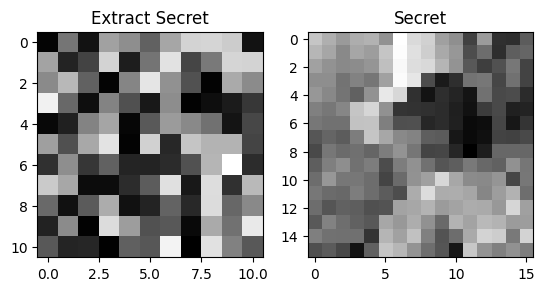

In [108]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_avg,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [109]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.7974084615707397
0.768646776676178


### 10)JPEG Compression

### code

In [110]:
def jpeg_compress(image, quality):
     cv2.imwrite('compress.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, quality])
     x=cv2.imread('compress.jpg',0)
     os.remove('compress.jpg')
     return x

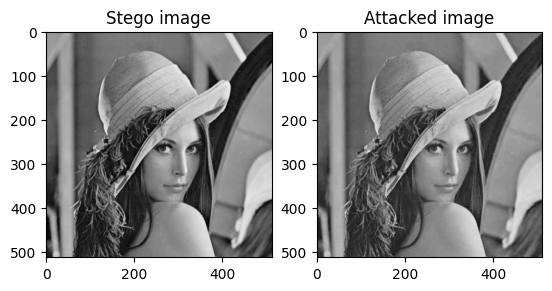

In [123]:
attack_img_jpeg= jpeg_compress(stego_img.astype(np.uint8),30)

plt.subplot(1,2,1)
plt.imshow(stego_img,cmap='gray')
plt.title('Stego image')
plt.subplot(1,2,2)
plt.imshow(attack_img_jpeg,cmap='gray')
plt.title('Attacked image')
plt.show()

ÉØÀ,C+lø9ÆÔQLqW,(ôZT¸êÐBsî2CkÞÑØ/Ja%ÂrÊo NH¾x6kWØ 7 1èàP, ÅANnPOP`ÌnjlÀr¥Úæ0#!J G`áxV]'@±¦=J¦¦kÓ*"V
  `;óVr&êPGãrþ1ÒÚññ4"I'­ä0÷ÁKpFÌ$(a<Yd×`D(Ü|q¾!§ìNµçi@6 &bØà


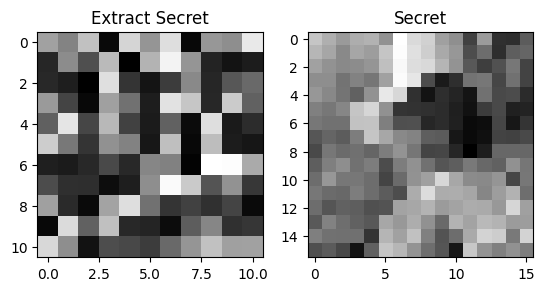

In [124]:
extract_secret_image, extract_sha_bin, extract_epr_bin=imageExtraction(attack_img_jpeg,bp1,bp2,bp3)
secret_after_cat=arnold_cat_map(extract_secret_image,iteration=5)
print(binary2text(extract_epr_bin))
plt.subplot(1,2,1)
plt.imshow(secret_after_cat.astype(np.uint8),cmap='gray')
plt.title('Extract Secret')
plt.subplot(1,2,2)
plt.imshow(secret.astype(np.uint8),cmap='gray')
plt.title('Secret')
plt.show()

In [125]:
print(NCC(extract_secret_image,secret_cat))
epr_inserted=binary2number(EPR_bin)
epr_extracted=binary2number(extract_epr_bin)

print(NCC(epr_inserted,epr_extracted))

0.7798099517822266
0.7570669054985046
